## Estimate weight of long range edges using appropriate penalizations for likelihoods

### Two models: 
1. instantantenous admixture (akin to TreeMix/SpaceMix model) - assume a single long range edge from $s$ to $d$ with some shared portion of the genome $c$. So, then $L^{\dagger_n}_{s,d} = (1-c) \times L^{\dagger_o}_{s,d} + c \times L^{\dagger_o}_{s,s}$

In [867]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2
import scipy as sp
from joblib import Parallel, delayed

# viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import seaborn as sns

# feems
import sys
sys.path.append('../../')
from feems import SpatialGraph, Viz, Objective
from feems.joint_ver import Joint_SpatialGraph, Joint_Objective, loss_wrapper
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes, simulate_genotypes_w_admixture
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv, run_cvq, run_cv_joint
from feems.helper_funcs import * 

# popgen
# import msprime
# import tskit
import allel

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": "Helvetica"
# })
plt.rcParams['axes.axisbelow'] = True
plt.style.use('bmh')
rng = np.random.default_rng(2022)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating a function to calculate Wishart likelihood from a matrix of pairwise resistance distances 

Easier to model $R$ as as function of admixture proportion $c$ instead of modeling $L^\dagger$ as a function of $c$ 

In [5]:
def get_FEEMS_demes_ll_w_c(sp_graph, obj, lrn, c, df=100, sigstar=1):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
    
    ## sd
    ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, df, -sigstar/df*C @ resmat @ C.T), sp.stats.linregress(np.ravel(2*C @ sp_graph.S @ C.T), np.ravel(-C @ resmat @ C.T))[2]**2
    # return sp.stats.wishart.logpdf(-C @ resmat @ C.T, df, 2*C @ sp_graph.S @ C.T) 

def get_FEEMS_demes_nll_w_c(c, sp_graph, obj, lrn, form='matrix'):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)       

    if(form!='matrix'):
        ##-----------------using the element-wise formulation----------------------##
        ## sd
        ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    else:
        ##-----------------using the matrix formulation----------------------##
        BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

        ## sd
        BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
        BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
        ## id
        for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            #id
            BR1[i,lrn[0][1]] = 1-c
            BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
            # sd
            BR2[i,lrn[0][1]] = c
            BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
            # is
            BR3[i,lrn[0][1]] = 0.5*(c**2-c)
            BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

        BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

        BQ1[lrn[0][0],lrn[0][1]] = 1+c
        BQ1[lrn[0][1],lrn[0][0]] = 1-c

        Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
        for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
            Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

            Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
            Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

            Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
            Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

            Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
            Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

        resmat = np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q)

    # return resmat
    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)

In [6]:
def get_FEEMS_demes_ll_w_c_x(sp_graph, obj, lrn, c, x):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    resmat = Rmat - 2*np.diag(1/sp_graph.q)
    
    ## sd
    ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (4*c*x-c**2*x+1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + (4*c*x-c**2*x+c)/sp_graph.q[lrn[0][0]]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T), sp.stats.linregress(np.ravel(2*C @ sp_graph.S @ C.T), np.ravel(-C @ resmat @ C.T))[2]**2

In [876]:
## writing code to pass in gradient wrt c (using scipy.optimize.minimize)
## this is basic code to check if the analytical derivative was found correctly and if I can code it up correctly 
def get_grad_FEEMS_demes_nll_w_c(c, opts):
    sp_graph = opts['sp_graph']; lrn = opts['lrn']

    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*opts['obj'].Linv + np.reshape(np.diag(opts['obj'].Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(opts['obj'].Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
    BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

    ## sd
    BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
    BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
    ## id
    for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        #id
        BR1[i,lrn[0][1]] = 1-c
        BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
        # sd
        BR2[i,lrn[0][1]] = c
        BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
        # is
        BR3[i,lrn[0][1]] = 0.5*(c**2-c)
        BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

    BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); #BQ2 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    BQ1[lrn[0][0],lrn[0][1]] = 1+c
    BQ1[lrn[0][1],lrn[0][0]] = 1-c

    Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
        Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

        Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
        Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

        Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
        Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

        Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
        Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

    resmat = -0.5*(np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q))

    ## construct derivative vectors
    ## using version from FEEMS appendix
    delldsig = sp_graph.n_snps * (C.T@(np.linalg.inv(C@resmat@C.T)@(C@sp_graph.S@C.T)@np.linalg.inv(C@resmat@C.T)-np.linalg.inv(C@resmat@C.T))@C).reshape(1,-1)
    
    dsigdc = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes))
    dsigdc[lrn[0][0],lrn[0][1]] = (c-1.5)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[lrn[0][0]] - 1/sp_graph.q[lrn[0][1]]
    dsigdc[lrn[0][1],lrn[0][0]] = dsigdc[lrn[0][0],lrn[0][1]]
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        dsigdc[i,lrn[0][1]] = -Rmat[i,lrn[0][1]] + Rmat[i,lrn[0][0]] + (c-0.5)*Rmat[lrn[0][0],lrn[0][1]] - 1/sp_graph.q[lrn[0][1]] + 1/sp_graph.q[lrn[0][0]]
        dsigdc[lrn[0][1],i] = dsigdc[i,lrn[0][1]]

    # dBR1 = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); dBR2 = np.zeros_like(dBR1); dBR3 = np.zeros_like(dBR1)
    # dBR1[lrn[0][0],lrn[0][1]] = c-1.5
    # dBR1[lrn[0][1],lrn[0][0]] = dBR1[lrn[0][0],lrn[0][1]]
    # ## id
    # for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
    #     #id
    #     dBR1[i,lrn[0][1]] = -1
    #     dBR1[lrn[0][1],i] = dBR1[i,lrn[0][1]]
    #     # sd
    #     dBR2[i,lrn[0][1]] = 1
    #     dBR2[lrn[0][1],i] = dBR2[i,lrn[0][1]]
    #     # is
    #     dBR3[i,lrn[0][1]] = c-0.5
    #     dBR3[lrn[0][1],i] = dBR3[i,lrn[0][1]]

    # dBQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    # dBQ1[lrn[0][0],lrn[0][1]] = 1
    # dBQ1[lrn[0][1],lrn[0][0]] = -1

    # dresmat = np.multiply(dBR1,Rmat) + np.multiply(dBR3,Rsdmat) + np.multiply(dBQ1,Q1mat) + np.multiply(Q1mat.T,dBQ1.T) + np.multiply(dBR2,Rismat+Qismat-Qidmat)
    # dsigdc = dresmat.reshape(-1,1)


    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, 1/sp_graph.n_snps*C @ resmat @ C.T), np.ravel(delldsig @ dsigdc.reshape(-1,1))[0]

In [877]:
get_grad_FEEMS_demes_nll_w_c(0.5,{'sp_graph':sp_graph,'obj':obj,'lrn':lrn})

(6676.598897261414, 3441.476170302975)

In [860]:
## figure out asymmetries in I here (2,7 & 7,2)
# sp_graph.c = 0
# dsigdL = np.zeros((sp_graph.n_observed_nodes**2,sp_graph.n_observed_nodes**2))
# idx = np.arange(sp_graph.n_observed_nodes**2).reshape(-1,sp_graph.n_observed_nodes).T[np.tril_indices(sp_graph.n_observed_nodes,k=-1)]   
# for I in idx:
#     i = I//sp_graph.n_observed_nodes; j = I%sp_graph.n_observed_nodes
#     dsigdL[I,sp_graph.n_observed_nodes*i+j] = 2*obj.Linv[i,j]**2
#     dsigdL[I,sp_graph.n_observed_nodes*j+i] = 2*obj.Linv[i,j]**2

#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2
#     dsigdL[I,sp_graph.n_observed_nodes*j+j] = -obj.Linv[j,j]**2

#     It = sp_graph.n_observed_nodes*j + i
#     dsigdL[It,sp_graph.n_observed_nodes*i+j] = 2*obj.Linv[j,i]**2
#     dsigdL[It,sp_graph.n_observed_nodes*j+i] = 2*obj.Linv[i,j]**2

#     dsigdL[It,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2
#     dsigdL[It,sp_graph.n_observed_nodes*j+j] = -obj.Linv[j,j]**2
        
# s = sp_graph.lre[0][0]; d = sp_graph.lre[0][1]
# I = sp_graph.n_observed_nodes*d + s 
# dsigdL[I,sp_graph.n_observed_nodes*s+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[s,d]**2)
# dsigdL[I,sp_graph.n_observed_nodes*d+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[d,s]**2)

# dsigdL[I,sp_graph.n_observed_nodes*s+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[s,s]**2)  
# dsigdL[I,sp_graph.n_observed_nodes*d+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[d,d]**2) 

# ## do it for transpose too
# I = sp_graph.n_observed_nodes*s + d 
# dsigdL[I,sp_graph.n_observed_nodes*s+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[s,d]**2)
# dsigdL[I,sp_graph.n_observed_nodes*d+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(2*obj.Linv[d,s]**2)

# dsigdL[I,sp_graph.n_observed_nodes*s+s] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[s,s]**2)  
# dsigdL[I,sp_graph.n_observed_nodes*d+d] = (0.5*sp_graph.c**2-1.5*sp_graph.c+1)*(-obj.Linv[d,d]**2) 

# for i in set(range(sp_graph.n_observed_nodes))-{s,d}:
#     I = sp_graph.n_observed_nodes*d + i
#     dsigdL[I,sp_graph.n_observed_nodes*i+d] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+i] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+s] = 0.5*(sp_graph.c**2+sp_graph.c)*(-obj.Linv[s,s]**2)

#     dsigdL[I,sp_graph.n_observed_nodes*d+d] = 0.5*(sp_graph.c**2-3*sp_graph.c+2)*(-obj.Linv[d,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+d] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+s] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2

#     I = sp_graph.n_observed_nodes*i + d
#     dsigdL[I,sp_graph.n_observed_nodes*i+d] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+i] = (1-sp_graph.c)*(2*obj.Linv[i,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+s] = 0.5*(sp_graph.c**2+sp_graph.c)*(-obj.Linv[s,s]**2)

#     dsigdL[I,sp_graph.n_observed_nodes*d+d] = 0.5*(sp_graph.c**2-3*sp_graph.c+2)*(-obj.Linv[d,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*s+d] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*d+s] = (sp_graph.c**2-sp_graph.c)*(obj.Linv[s,d]**2)
#     dsigdL[I,sp_graph.n_observed_nodes*i+i] = -obj.Linv[i,i]**2

# print(np.divide(dsigdL,np.repeat((obj.Linv**2).reshape(16,1),16,axis=0).reshape(16,16,order='F')))

# dLdw = np.zeros((sp_graph.n_observed_nodes**2,len(sp_graph.edges)))
# for I in range(len(sp_graph.edges)):
#     Ii = list(sp_graph.edges)[I][0]; Ij = list(sp_graph.edges)[I][1]

#     dLdw[sp_graph.n_observed_nodes*Ii + Ij, I] = -1
#     dLdw[sp_graph.n_observed_nodes*Ij + Ii, I] = -1

# for i in range(sp_graph.n_observed_nodes):
#     for j in np.where(sp_graph.Delta_q.toarray()[:,i])[0]:
#         dLdw[sp_graph.n_observed_nodes*i + i, j] = 1

# print(dLdw)

# plt.imshow(dLdw[-500:,], aspect='auto', cmap='RdBu',norm=mpl.colors.TwoSlopeNorm(0)); plt.colorbar()
# plt.imshow(dLdw,aspect='auto',cmap='RdBu',norm=mpl.colors.TwoSlopeNorm(0)); plt.colorbar()


(3.9627958414810815, 3.451896453556947)

In [865]:
# np.where(sp_graph.adj_base.toarray())
# sp_graph.edges, np.where(sp_graph.adj_base.toarray())
[(-2, 3)] * 10 + [(0,1)]

[(-2, 3),
 (-2, 3),
 (-2, 3),
 (-2, 3),
 (-2, 3),
 (-2, 3),
 (-2, 3),
 (-2, 3),
 (-2, 3),
 (-2, 3),
 (0, 1)]

Text(0, 0.5, 'weights with $c=0$')

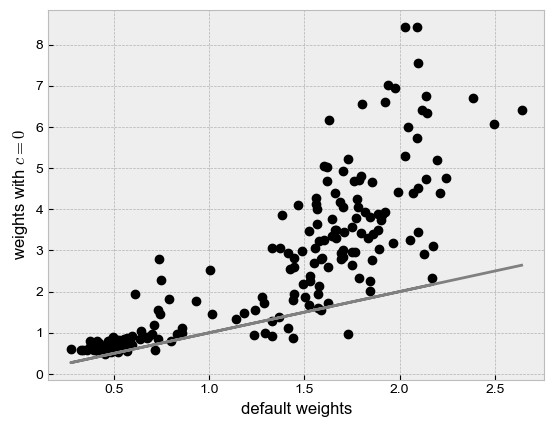

In [851]:
# n_rows, n_columns = 8, 10
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1., barrier_w=0.2, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=7, n_samples_per_node=30)
# gen_test_6 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000)
# sp_graph = Joint_SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3., optimize_q='n-dim', option='default')
# defw = sp_graph.w; defq = sp_graph.q
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# gr = obj.grad_obj 
# sp_graph = Joint_SpatialGraph(gen_test_80, coord_def, grid_def, edge_def, long_range_edges=[(0,29)], c=0)
# sp_graph.fit(lamb=3., optimize_q='n-dim', option='joint')
# jtw = sp_graph.w; jtq = sp_graph.q
# obj = Joint_Objective(sp_graph, option= 'joint'); obj.inv(); obj.grad(reg=False)
# grjt = obj.grad_obj

plt.plot(defw, jtw, 'ko'); plt.plot(defw,defw,ls='-',color='grey'); plt.xlabel('default weights'); plt.ylabel('weights with $c=0$')
# plt.plot(defq, jtq, 'ko'); plt.plot(defq,defq,ls='-',color='grey'); plt.xlabel('default $q$'); plt.ylabel('$q$ with $c=0$')
# plt.plot(gr, grjt, 'ko'); plt.plot(gr,gr,ls='-',color='grey'); plt.xlabel('gradient of obj (default)'); plt.ylabel('gradient of obj (with $c=0$)')

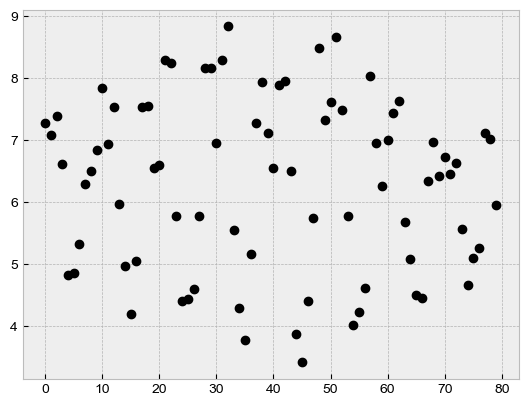

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/viz.py:146: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.idx = nx.adjacency_matrix(self.sp_graph).nonzero()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/viz.py:331: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  idx = nx.adjacency_matrix(sp_graph).nonzero()


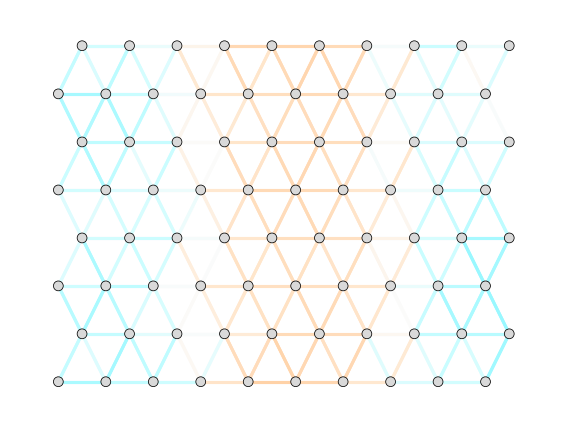

In [849]:
fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, #weights=w,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)

# plt.plot(defq, jtq, 'ko'); plt.plot(defq,defq,ls='-',color='grey');
# plt.plot(jtw0, jtw, 'ko'); plt.plot(defq,defq,ls='-',color='grey');

LinregressResult(slope=0.0008447734823054908, intercept=-0.09110141029188856, rvalue=0.9801114865818458, pvalue=0.0, stderr=2.1654755464160985e-06, intercept_stderr=0.0018212738710352593)


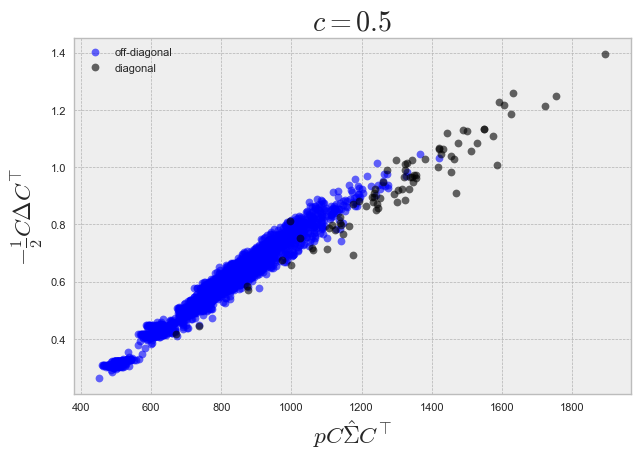

In [1199]:
# J = np.zeros((np.sum(sp_graph.n_samples_per_obs_node_permuted),sp_graph.n_observed_nodes))
# cnt = 0
# for o in range(sp_graph.n_observed_nodes):
#     J[cnt:(cnt+sp_graph.n_samples_per_obs_node_permuted[o]+1),o] = 1
#     cnt += sp_graph.n_samples_per_obs_node_permuted[o]

C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

# Pairs = sp_graph.n_samples_per_obs_node_permuted.reshape(-1,1,) @ sp_graph.n_samples_per_obs_node_permuted.reshape(1,-1) - np.diag(sp_graph.n_samples_per_obs_node_permuted)
# Dstar = squareform(pdist(J.T@sp_graph.genotypes,"sqeuclidean"))/1500/Pairs#J.T@(squareform(pdist(gen_test_1e,"sqeuclidean"))/gen_test_1e.shape[1])@J/Pairs
# Dstar = squareform(pdist(sp_graph.frequencies*np.sqrt(sp_graph.mu*(1-sp_graph.mu)),"sqeuclidean"))/1500 ## this does not give us good results (needs to be 'scaled' by SNP factor)
Dstar = squareform(pdist(sp_graph.frequencies,"sqeuclidean"))/1500
# resmat = -2*obj.Linv- np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T - np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) #np.zeros_like(obj.Linv) 
# resmat = -2*obj.Linv-2*np.diag(1/sp_graph.q)
# resmat = resmat - np.diag(resmat)
# for i in range(obj.Linv.shape[0]):
#     for j in range(i,obj.Linv.shape[0]):
#         resmat[i,j] = -2*obj.Linv[i,j] + Linv[i,i] + Linv[j,j] #+ sp_graph.q[i] + sp_graph.q[j]
#         resmat[j,i] = resmat[i,j]
#         if i==j:
#             resmat[i,i] -= 2/sp_graph.q[i]
Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
# Qmat = np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))
Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
c = 0.5
resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]
for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
    resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
    resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]
# plt.imshow(-C@Dstar@C.T); plt.colorbar(); plt.title(r'$-CDC^\top$'); plt.show()
# plt.imshow(-0.5*resmat,); plt.colorbar(); plt.title(r'$\Delta $')
# np.diag(C@resmat@C.T), sp_graph.q

print(sp.stats.linregress(np.ravel(sp_graph.n_snps*C@sp_graph.S@C.T),np.ravel(-0.5*C@resmat@C.T)))
plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],(-0.5*C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.xlabel(r'$pC\hat \Sigma C^\top$'); plt.ylabel(r'$-\frac{1}{2}C\Delta C^\top$'); 
plt.plot(np.diag(sp_graph.n_snps*C@sp_graph.S@C.T),np.diag(-0.5*C@resmat@C.T),'ko',label='diagonal',alpha=0.6); plt.title(r'$c={}$'.format(c,0.975)); plt.legend();
# plt.imshow(2*C@sp_graph.S@C.T,cmap='Greys',); plt.colorbar(); plt.title('observed covariance matrix'); plt.show()
# plt.imshow(-C@resmat@C.T,cmap='Greys'); plt.title(r'$c=1.$'); plt.colorbar()
plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[:,lrn[0][1]-1],(-0.5*C@resmat@C.T)[:,lrn[0][1]-1],'g+',label='id'); plt.plot((sp_graph.n_snps*C@sp_graph.S@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-0.5*C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],'rx',label='dd'); 

In [525]:
np.random.uniform(0,100,20)

array([35.32626821, 42.93064146, 95.5896558 , 68.73503657, 95.87099835,
       14.40955948, 51.9893002 , 41.39565527,  6.97568186, 48.04049856,
       41.36355641, 62.10633785, 18.66812037, 93.91919598, 82.4952338 ,
       73.65785562, 18.81716724, 22.46965551,  0.38908075, 73.32435144])

In [1454]:
# randedge = [tuple(np.random.choice(range(80),size=2,replace=False)) for _ in range(30)]
# randedge = list(set(randedge)-set(sp_graph.edges)); 
# truew = np.append(np.zeros(len(randedge)),[0.6,0,0,0,0,0,])
# for e in [(23,56),(22,56),(24,56),(23,57),(23,55),(24,55)]:
#     randedge.append(e)
# for e in [(56,23),(56,22),(56,24),(57,23),(55,23),(55,24)]:
#     randedge.append(e)
# for e in [(8,27),(7,27),(9,27),(8,26),(8,28)]:
#     randedge.append(e)
# for e in [(23,92),(22,92),(91,23),(92,24),(101,36),(102,36),(35,101),(117,36),(35,118)]:
#     randedge.append(e)
# print(randedge)

# isc2 = np.zeros(len(randedge))
for ie, e in enumerate(randedge):
    # llc = []
    # for c in np.linspace(0,1,25): 
    #     # llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [e], c, df=1500, sigstar=0.5)[1])
    #     try: 
    #         llc.append(-get_FEEMS_demes_nll_w_c(c, sp_graph, obj, [e], form='matrix'))
    #     except:
    #         llc.append(-1e8)
    # logc[ie] = np.linspace(0,1,12)[np.argmin(np.abs(llc-np.max(llc)+2))] # llc[0] - llc[-1]
    # if np.argmax(llc)!=0:
    #     isc[ie] = 1
    # isc2[ie] = np.linspace(0,1,25)[np.argmax(llc)]
    isc2[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=True,method='Nelder-Mead',bounds=[[0,1]]).x
    isc[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=True,method='L-BFGS-B',bounds=[[0,1]]).x

In [1784]:
# plt.style.use('fivethirtyeight')
# plt.plot(grid_def[:,0],grid_def[:,1],'o',color='grey',alpha=0.8); plt.box(False); plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False); plt.grid()
# plt.plot(grid_def[lrn[1][0],0],grid_def[lrn[1][0],1],'bo'); plt.plot(grid_def[lrn[1][1],0],grid_def[lrn[1][1],1],'bo'); plt.box(False); plt.tick_params(left = False, labelleft = False, labelbottom = False, bottom = False); plt.grid()
# for ie, e in enumerate(randedge):
# for ie in range(-6,0):
#     plt.plot((grid_def[randedge[ie][0],0],grid_def[randedge[ie][1],0]),(grid_def[randedge[ie][0],1],grid_def[randedge[ie][1],1]),color='{}'.format(1-np.abs(isc[ie]-truew[ie])),markersize=1)
# plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=mpl.cm.Greys), orientation='vertical', label=r'$ |\hat c - c_{sim}|$')
# plt.plot(grid_def[lrn[0][0],0],grid_def[lrn[0][0],1],'bo',markersize=8); plt.plot(grid_def[lrn[0][1],0],grid_def[lrn[0][1],1],'bo',markersize=8);
# plt.style.use('seaborn-whitegrid')

# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=False)
# for ie in range(len(randedge)):
#     v.draw_arrow([randedge[ie]],np.abs(isc[ie]-truew[ie]))
# ax.scatter(v.grid[lrn[0][0],0],v.grid[lrn[0][0],1],marker='o',color='b'); ax.scatter(v.grid[lrn[0][1],0],v.grid[lrn[0][1],1],marker='o',color='b');
# v.draw_c_colorbar()

(-9178.109179586696, -8575.380575026647)

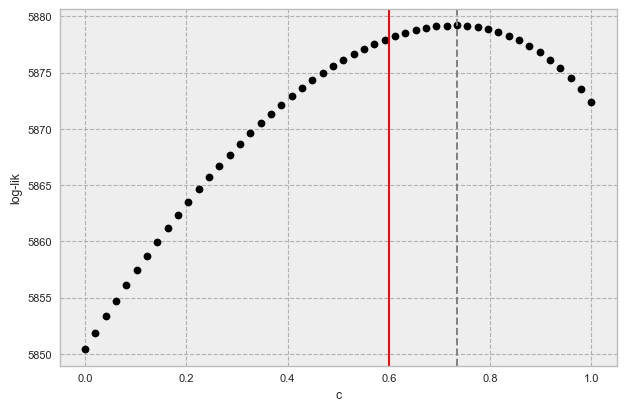

In [1781]:
# sp_graph.fit(lamb=3.,optimize_q='n-dim'); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
llc = []
for c in np.linspace(0,1,50): 
    llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, [(23,56)], c,)[0])
    # llc.append(-get_FEEMS_demes_nll_w_c(c, sp_graph, obj, [(56,23)], form='matrix'))
plt.plot(np.linspace(0,1,50),llc,'ko'); plt.xlabel(r'c'); plt.ylabel(r'log-lik'); plt.axvline(0.6,color='red'); 
plt.axvline(np.linspace(0,1,50)[np.argmax(llc)],color='grey',ls='--')

In [886]:
## starting fresh with a simple 6x6 grid to see if the computed log-lik from FEEMS is correlated with my function
# n_rows, n_columns = 6, 6
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1., barrier_w=1, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)

# lrn = [(8,27)] # lrn=[(23,92),(101,36)]
# gen_test_80_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, long_range_nodes=lrn, admixture_props=[0.6], time_of_adm=[0.000001])
# gen_test_128_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, long_range_nodes=lrn, admixture_props=[0.6], time_of_adm=[3])
# gen_test_128 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000, mu=1)
# sp_graph = Joint_SpatialGraph(gen_test_1e, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3.,optimize_q='n-dim'); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 

# estcR2mat = np.zeros((16,5)); 
estcllmat = np.zeros((16,5))
for ic, truec in enumerate([0,0.25,0.5,0.75,1]):
    for n in range(16):
# #         # gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, long_range_nodes=lrn, admixture_props=[truec], time_of_adm=[0.000001])
# #         # np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),n),gen_test_36_adm,delimiter=',',fmt='%f')
        gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),n),delimiter=',')
        sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def); sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3); 
        obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 

        # estcR2mat[n,ic] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=rng.uniform(),args=({'sp_graph':sp_graph,'obj':obj,'lrn':lrn}),jac=False,method='Nelder-Mead',bounds=[[0,1]]).x
        estcllmat[n,ic] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=rng.uniform(),args=({'sp_graph':sp_graph,'obj':obj,'lrn':lrn}),jac=True,method='L-BFGS-B',bounds=[[0,1]]).x 

constant-w/variance fit, converged in 134 iterations, train_loss=-21023.1092525
lambda=3.0000000, alpha=0.5400887, converged in 7 iterations, train_loss=-21218.6576229
constant-w/variance fit, converged in 131 iterations, train_loss=-21082.6238593
lambda=3.0000000, alpha=0.5319569, converged in 7 iterations, train_loss=-21400.2782826
constant-w/variance fit, converged in 126 iterations, train_loss=-20264.8026475
lambda=3.0000000, alpha=0.5442734, converged in 6 iterations, train_loss=-20517.4070772
constant-w/variance fit, converged in 132 iterations, train_loss=-20803.0547504
lambda=3.0000000, alpha=0.5854256, converged in 7 iterations, train_loss=-21211.1577059
constant-w/variance fit, converged in 134 iterations, train_loss=-20121.2061186
lambda=3.0000000, alpha=0.5313770, converged in 6 iterations, train_loss=-20414.4515439
constant-w/variance fit, converged in 138 iterations, train_loss=-20403.8296286
lambda=3.0000000, alpha=0.5516292, converged in 6 iterations, train_loss=-20658.

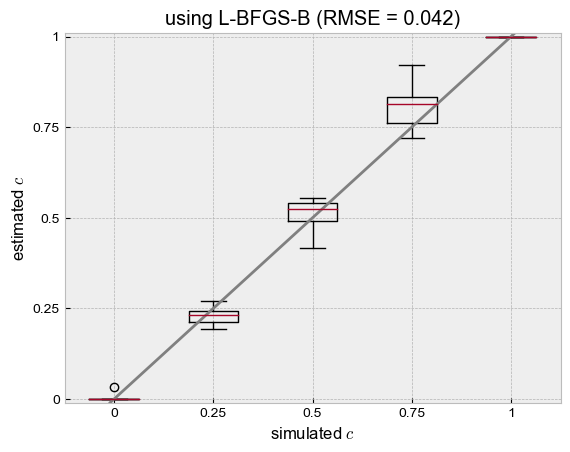

In [887]:
# plt.boxplot(estcR2mat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'RMSE = {}, $\lambda_q = 0.1, \alpha_q = 1$'.format(np.round(np.sqrt(np.mean((estcR2mat-np.array([0,0.25,0.5,0.75,1]))**2)),3))); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.show() #plt.axline((1,0),slope=0.25,color='grey'); 
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'using L-BFGS-B (RMSE = {})'.format(np.round(np.sqrt(np.mean((estcllmat-np.array([0,0.25,0.5,0.75,1]))**2)),3))); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.axline((1,0),slope=0.25,color='grey'); 
# gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(25,10),delimiter=',')
# sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def); sp_graph.fit(lamb=3.,optimize_q='n-dim'); 
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel('LL(correct) - LL(wrong)'); plt.axhline(1.,color='grey',ls='--'); 

In [944]:
# lamb_grid = np.geomspace(1e-1,100,10,endpoint=True)[::-1]
# cvq_err = run_cv_joint(sp_graph_jt, lamb_grid=lamb_grid, lamb_q_grid=lamb_grid)
# print(lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,2)))], lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,1)))])
# plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,1)),'k-o',label=r'$\lambda_w $'); plt.xlabel('values'); plt.ylabel('LOO CV error'); plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,2)),'-o',color='grey',label=r'$\lambda_q$'); plt.semilogx(); plt.legend(); 
# sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def, long_range_edges=[(8,27)],c=0.2);
sp_graph.fit(lamb=3.,optimize_q='n-dim',option='joint',lamb_q=3.,alpha_q=.3);

constant-w/variance fit, converged in 135 iterations, train_loss=-18288.8713285
lambda=3.0000000, alpha=0.5094034, converged in 6 iterations, train_loss=-18523.9441627


### Methods that DO NOT penalize long range edges (test the code here...)

The idea being that currently fitting graphs with many long range edges causes convergence issues, so we want to be able to add edges to the graph that are not constrained.

This will involve removing the penalty term + gradient term for these long range edges. Just need to index it correctly. 

In [262]:
edges_lr = deepcopy(edge_def)
edges_lr = edges_lr.tolist()
edges_lr.append(list(x+1 for x in (8,27)))
# sp_graph_lr = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, np.array(edges_lr), long_range_edges=[(23,56)])
# sp_graph_lr.fit(lamb=3., optimize_q='n-dim')
# plt.hist(sp_graph_lr.w); plt.axvline(sp_graph_lr.w[25],color='k')
# obj_lr = Joint_Objective(sp_graph_lr); obj_lr.lamb = 3.; obj_lr.alpha = 0.5
# obj_lr.inv(); obj_lr.grad(reg=True)

estwsmat = np.zeros((14,30)); estwdmat = np.zeros_like(estwsmat)[:12,:] # 0:7 rows-penalizing LRE, 7:14 rows-not (dest mat does not need LRE again)
for ic, truec in enumerate([0]*10+[0.5]*10+[1]*10):
    gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),ic%10),delimiter=',')
    sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, np.array(edges_lr)); sp_graph.fit(lamb=3.,optimize_q='n-dim', verbose=False); 
    for idn, n in enumerate([2, 3, 7, 9, 14, 15, 27]):
        if n<8:
            estwsmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((n,8))]
        else:
            estwsmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((n,27))]
        else:
            estwdmat[idn,ic] = sp_graph.w[list(sp_graph.edges).index((27,n))]

    sp_graph_lr = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, np.array(edges_lr), long_range_edges=[(8,27)]) 
    try: 
        sp_graph_lr.fit(lamb=3.,optimize_q='n-dim', verbose=False); 
    except:
        sp_graph_lr.fit(lamb=4.,optimize_q='n-dim', verbose=False); 
    for idn, n in enumerate([2, 3, 7, 9, 14, 15, 27]):
        if n<8:
            estwsmat[idn+7,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((n,8))]
        else:
            estwsmat[idn+7,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((8,n))]
    for idn, n in enumerate([20, 21, 26, 28, 33, 32]):
        if n<27:
            estwdmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((n,27))]
        else:
            estwdmat[idn+6,ic] = sp_graph_lr.w[list(sp_graph_lr.edges).index((27,n))]
# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph_lr, projection=ccrs.Mercator(), edge_width=2, #weights=w,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False)
# # get_best_lre(sp_graph, gen_test_128_adm, coord_def, grid_def, edge_def, k=2, top=10)

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:56: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.Delta_q = nx.incidence_matrix(self, oriented=True).T.tocsc()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:59: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.adj_base = sp.triu(nx.adjacency_matrix(self), k=1)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:65: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:69: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:187: RuntimeWarning: invalid value encountered in lo

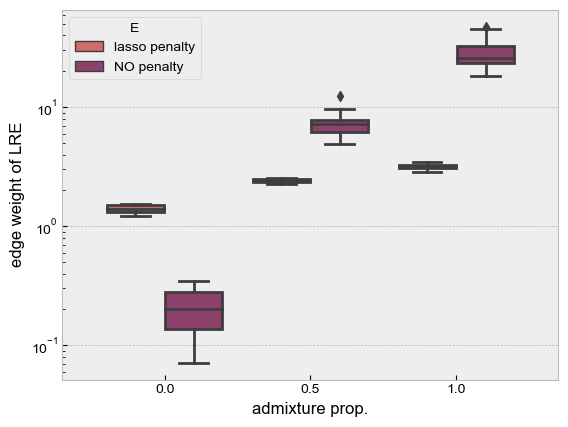

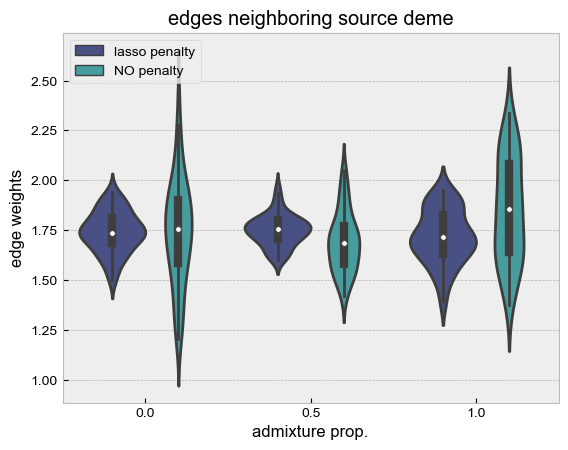

Ttest_indResult(statistic=-1.2165606063298824, pvalue=0.22706243378250174)

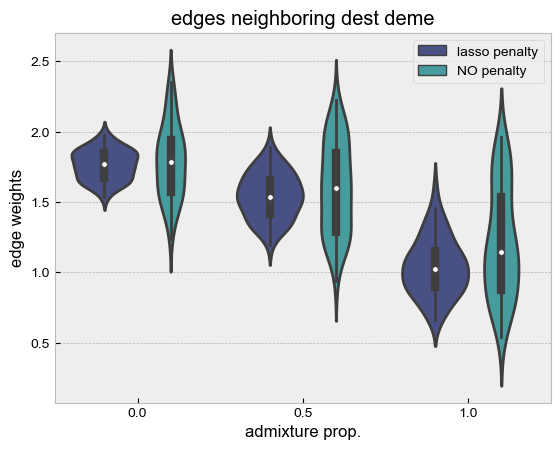

In [263]:
## Delta is shape inds x edges
# df = pd.DataFrame(np.random.rand(20,3), columns=[0,0.5,1])
df['E'] = ['lasso penalty']*10+['NO penalty']*10
df.iloc[:10,0:3] = estwsmat[6,:].reshape(10,-1,order='F')
df.iloc[10:,0:3] = estwsmat[13,:].reshape(10,-1,order='F')
sns.boxplot(df.melt(id_vars=['E'], value_vars=[0,0.5,1]), x='variable', y='value', hue='E', palette='flare'); plt.semilogy(); plt.xlabel('admixture prop.');
plt.ylabel('edge weight of LRE'); plt.show()

df2s = pd.DataFrame(np.random.rand(120,3), columns=[0,0.5,1])
df2s['E'] = ['lasso penalty']*60+['NO penalty']*60
df2s.iloc[:60,0:3] = estwsmat[0:6,:].reshape(60,-1,order='F')
df2s.iloc[60:,0:3] = estwsmat[7:13,:].reshape(60,-1,order='F')
sns.violinplot(df2s.melt(id_vars=['E'], value_vars=[0,0.5,1]), x='variable', y='value', hue='E', palette='mako'); plt.legend(loc='upper left')
plt.xlabel('admixture prop.'); plt.ylabel('edge weights'); plt.title('edges neighboring source deme')
sp.stats.ttest_ind(df2s.iloc[:60,0],df2s.iloc[:60,2],equal_var=False); plt.show()

df2d = pd.DataFrame(np.random.rand(120,3), columns=[0,0.5,1])
df2d['E'] = ['lasso penalty']*60+['NO penalty']*60
df2d.iloc[:60,0:3] = estwdmat[0:6,:].reshape(60,-1,order='F')
df2d.iloc[60:,0:3] = estwdmat[6:12,:].reshape(60,-1,order='F')
sns.violinplot(df2d.melt(id_vars=['E'], value_vars=[0,0.5,1]), x='variable', y='value', hue='E', palette='mako'); plt.legend(loc='upper right'); 
plt.xlabel('admixture prop.'); plt.ylabel('edge weights'); plt.title('edges neighboring dest deme')
sp.stats.ttest_ind(df2d.iloc[:60,1],df2d.iloc[60:,1],equal_var=False)

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/viz.py:146: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.idx = nx.adjacency_matrix(self.sp_graph).nonzero()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/viz.py:331: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  idx = nx.adjacency_matrix(sp_graph).nonzero()


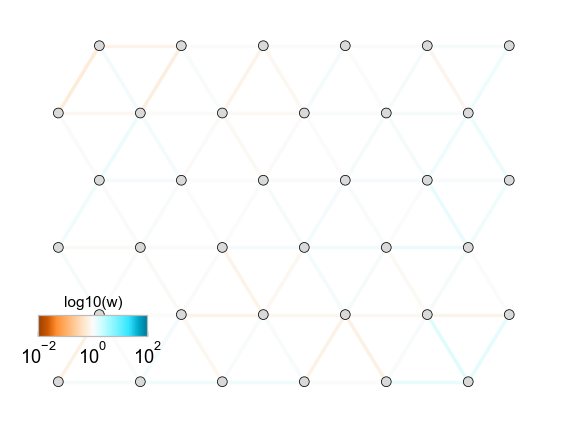

In [945]:
fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, #weights=w,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
# get_best_lre(sp_graph, gen_test_128_adm, coord_def, grid_def, edge_def, k=2, top=10)
v.draw_edge_colorbar()
# v.draw_c_colorbar()

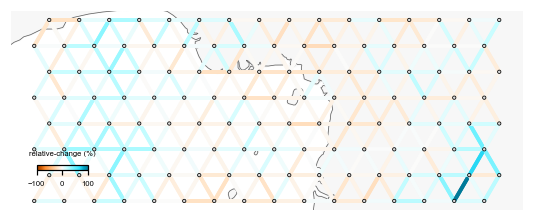

In [338]:
foldchange = (sp_graph_lr.w[~sp_graph_lr.lre_idx]-sp_Graph_def_jt.w)*100/sp_Graph_def_jt.w
fig = plt.figure(dpi=110) 
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_Graph_def_jt, projection=projection, edge_width=2.5, newweights=sp_graph_lr.w[~sp_graph_lr.lre_idx],
        edge_alpha=1, edge_zorder=100, sample_pt_size=2, halfrange=100,
        obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=5,
        cbar_font_size=5, cbar_width='10%',cbar_height='2.5%')
v.draw_map()
v.draw_edges(use_weights=True, use_foldchange=True)
v.draw_obs_nodes()
# v.draw_edge_colorbar()
v.draw_edge_change_colorbar()

## Demes with small sample sizes

Scenarios:
1. NO long range edges but with few demes with small samples (<10% of larger demes)
2. ONE long range edge but between demes with large samples 

In [584]:
# n_rows, n_columns = 8, 10
# smallnodes = [12, 62,  9, 37, 25, 48, 53, 76]
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[4 if i in smallnodes else 40 for i in range(80)]) 
# gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1000)

# sp_Graph = Joint_SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_Graph.fit(lamb=3., optimize_q='n-dim')
# obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

# print(get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1, top=20))

# lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1)

# nreps = 30
# fit_dist = np.zeros((sp_Graph.n_observed_nodes*(sp_Graph.n_observed_nodes-1)//2,nreps+1)); emp_dist = np.zeros_like(fit_dist)
# ss = rng.bit_generator._seed_seq; child_states = ss.spawn(nreps)
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist[:,0] = cov_to_dist(fit_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]
# emp_dist[:,0] = cov_to_dist(emp_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]

for n in range(1,nreps+1):
    bootgenotypes = deepcopy(gen_test_80)
    ## if we bootstrap over SNPs, then we can do the below
    ## bootgenotypes[:,rng.choice(range(gen_test_1e.shape[1]),gen_test_1e.shape[1])]
    ## bootstrapping over inds (since this is the source of uncertainty)
    ctr = 0
    for deme in range(sp_Graph.n_observed_nodes):
        bootgenotypes[ctr:(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme]),:] = gen_test_80[rng.choice(range(ctr,(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme])),sp_Graph.n_samples_per_obs_node_permuted[deme],replace=True),:]
        ctr += sp_Graph.n_samples_per_obs_node_permuted[deme]
    ## remove SNPs that are invariant after bootstrapping
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
    bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
    sp_graph_boot = Joint_SpatialGraph(bootgenotypes, coord_def, grid_def, edge_def)
    sp_graph_boot.fit(lamb=3., optimize_q='n-dim', verbose=False)
    obj_boot = Joint_Objective(sp_graph_boot)
    fit_cov, _, emp_cov = comp_mats(obj_boot)
    fit_dist[:,n] = cov_to_dist(fit_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]
    emp_dist[:,n] = cov_to_dist(emp_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:57: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.Delta_q = nx.incidence_matrix(self, oriented=True).T.tocsc()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/spatial_graph.py:60: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.adj_base = sp.triu(nx.adjacency_matrix(self), k=1)


<ErrorbarContainer object of 3 artists>

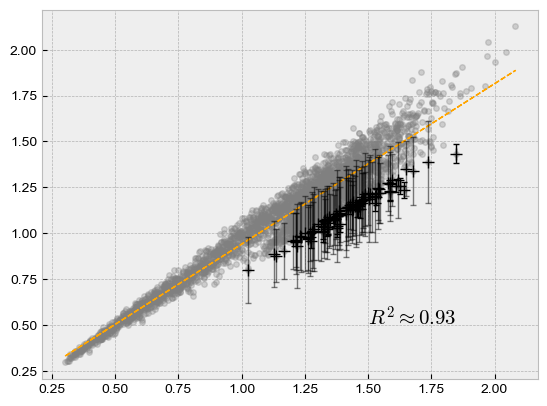

In [631]:
# X = sm.add_constant(fit_dist[:,0])
# mod = sm.OLS(emp_dist[:,0], X)
# res = mod.fit()
# muhat, betahat = res.params
# # computing the standard errors from before
# se_fit = np.zeros(fit_dist.shape[0]); se_emp = np.zeros_like(se_fit)
# for i in range(fit_dist.shape[0]):
#     se_fit[i] = np.sqrt(np.sum((fit_dist[i,:]-np.mean(fit_dist[i,:]))**2)/(nreps-1))
#     se_emp[i] = np.sqrt(np.sum((emp_dist[i,:]-np.mean(emp_dist[i,:]))**2)/(nreps-1))
# # finding the largest outliers, taking into account the SE might overlap with best-fit line
# max_idx = np.argpartition(res.resid, 100)[:100]
# max_idx = max_idx[np.argsort(res.resid[max_idx])]
# new_max_idx = []
# for i in max_idx:
#     if ((fit_dist[i,0]-se_fit[i])>(emp_dist[i,0]-muhat)/betahat) & ((betahat*fit_dist[i,0]+muhat) > (emp_dist[i,0]+se_emp[i])):
#         new_max_idx.append(i)

# new_max_res_node = []
# for k in new_max_idx:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
#     y = int(k - 0.5*x*(x-1))
#     new_max_res_node.append(tuple(sorted((x,y))))

# plt.plot(fit_dist[:,0], emp_dist[:,0], 'o', color='grey', alpha=0.3, markersize=4)
# plt.plot(fit_dist[:,0], betahat*fit_dist[:,0]+muhat, color='orange', ls='--', lw=1)
# plt.text(1.5, 0.5, r'$R^2 \approx 0.93$', fontsize=15)
# plt.plot(fit_dist[max_idx,0], emp_dist[max_idx,0], '+', color='black', markersize=8)
# plt.errorbar(fit_dist[new_max_idx[20:],0], emp_dist[new_max_idx[20:],0], yerr=np.random.uniform(3,5,size=80)*se_emp[new_max_idx[20:]], color='k', lw=1, capsize=2, capthick=1, ls='none', alpha=0.5)
# plt.errorbar(fit_dist[new_max_idx[:20],0], emp_dist[new_max_idx[:20],0], yerr=se_emp[new_max_idx[:20]], color='black', lw=1, capsize=2, capthick=1, ls='none')

In [330]:
## for the case with NO admixture BUT correction for standard errors
# llinc = np.zeros(30,); topedge = np.zeros((30,3),dtype='int'); 
# n_rows, n_columns = 8, 10
for n in range(4):
    # smallnodes = np.random.choice(range(80),8,replace=False)
    # smallnodes = [12, 62, 9, 37, 25, 48, 53, 76]

    # graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[4 if i in smallnodes else 40 for i in range(80)]) 

    # gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1200)
    # np.savetxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/gen80small{}.txt'.format(n),gen_test_1e,fmt='%f')
    gen_test_1e = np.loadtxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/gen80small{}.txt'.format(n))

    sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
    sp_Graph.fit(lamb=3., optimize_q='n-dim', verbose=False)
    obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

    ## searching for best outlier node out of 20
    lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
    llinc[n] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
    ee = te.iloc[np.argmax(lle),0]
    if ((ee[0] in smallnodes) & (ee[1] in smallnodes)):
        topedge[n,0] += 1
    elif ((ee[0] in smallnodes) | (ee[1] in smallnodes)):
        topedge[n,1] += 1
    else:
        topedge[n,2] += 1
    
    ## running the bootstrapping mechanism
    nreps = 20
    fit_dist = np.zeros((sp_Graph.n_observed_nodes*(sp_Graph.n_observed_nodes-1)//2,nreps+1)); emp_dist = np.zeros_like(fit_dist)
    ss = rng.bit_generator._seed_seq; child_states = ss.spawn(nreps)
    fit_cov, _, emp_cov = comp_mats(obj)
    fit_dist[:,0] = cov_to_dist(fit_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]
    emp_dist[:,0] = cov_to_dist(emp_cov)[np.tril_indices(sp_Graph.n_observed_nodes, k=-1)]

    for n in range(1,nreps+1):
        bootgenotypes = deepcopy(gen_test_1e)
        ## if we bootstrap over SNPs, then we can do the below
        ## bootgenotypes[:,rng.choice(range(gen_test_1e.shape[1]),gen_test_1e.shape[1])]
        ## bootstrapping over inds (since this is the source of uncertainty)
        ctr = 0
        for deme in range(sp_Graph.n_observed_nodes):
            bootgenotypes[ctr:(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme]),:] = gen_test_1e[rng.choice(range(ctr,(ctr+sp_Graph.n_samples_per_obs_node_permuted[deme])),sp_Graph.n_samples_per_obs_node_permuted[deme],replace=True),:]
            ctr += sp_Graph.n_samples_per_obs_node_permuted[deme]
        ## remove SNPs that are invariant after bootstrapping
        bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
        bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
        sp_graph_boot = Joint_SpatialGraph(bootgenotypes, coord, grid, edge)
        sp_graph_boot.fit(lamb=3., optimize_q='n-dim',verbose=False)
        obj_boot = Joint_Objective(sp_graph_boot)
        fit_cov, _, emp_cov = comp_mats(obj_boot)
        fit_dist[:,n] = cov_to_dist(fit_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]
        emp_dist[:,n] = cov_to_dist(emp_cov)[np.tril_indices(sp_graph_boot.n_observed_nodes, k=-1)]

    X = sm.add_constant(fit_dist[:,0])
    mod = sm.OLS(emp_dist[:,0], X)
    res = mod.fit()
    muhat, betahat = res.params
    # computing the standard errors from before
    se_fit = np.zeros(fit_dist.shape[0]); se_emp = np.zeros_like(se_fit)
    for i in range(fit_dist.shape[0]):
        se_fit[i] = np.sqrt(np.sum((fit_dist[i,:]-np.mean(fit_dist[i,:]))**2)/(nreps-1))
        se_emp[i] = np.sqrt(np.sum((emp_dist[i,:]-np.mean(emp_dist[i,:]))**2)/(nreps-1))
    # finding the largest outliers, taking into account the SE might overlap with best-fit line
    max_idx = np.argpartition(res.resid, 100)[:100]
    max_idx = max_idx[np.argsort(res.resid[max_idx])]
    new_max_idx = []
    for i in max_idx:
        if ((fit_dist[i,0]-se_fit[i])>(emp_dist[i,0]-muhat)/betahat) & ((betahat*fit_dist[i,0]+muhat) > (emp_dist[i,0]+se_emp[i])):
            new_max_idx.append(i)

    new_max_res_node = []
    for k in new_max_idx:
        x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
        y = int(k - 0.5*x*(x-1))
        new_max_res_node.append(tuple(sorted((x,y))))

    ll_edges = np.zeros((20,)); 
    for ie, e in enumerate(new_max_res_node[:20]):
        edges_t = deepcopy(edge.tolist())
        edges_t.append(list(x+1 for x in e))
        sp_graph_lr = Joint_SpatialGraph(gen_test_1e, coord, grid, np.array(edges_t), long_range_edges=new_max_res_node[ie:(ie+1)])
        sp_graph_lr.fit(lamb=3., optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2),verbose=False)
        obj_lr = Joint_Objective(sp_graph_lr); obj_lr.inv(); 
        ll_edges[ie] = -obj_lr.neg_log_lik()

    print(new_max_res_node[np.argmax(ll_edges)])

    if ee not in new_max_res_node:
        print("sim {}: top edge NOT found after correction. {}/20 left...\n".format(n, np.sum([te.iloc[i,0] in new_max_res_node for i in range(20)])))
    else:
        print("sim {}: {}/20 left...\n".format(n, np.sum([te.iloc[i,0] in new_max_res_node for i in range(20)])))

constant-w/variance fit, converged in 97 iterations, train_loss=-12150.6965079
lambda=3.0000000, alpha=0.7951398, converged in 12 iterations, train_loss=-13052.9709750
Starting search for edge 1...
(12, 37), found at index 0.
constant-w/variance fit, converged in 101 iterations, train_loss=-12294.3420486
lambda=3.0000000, alpha=0.8085983, converged in 9 iterations, train_loss=-14193.3519312
(71, 78)
sim 20: top edge NOT found after correction. 0/20 left...

constant-w/variance fit, converged in 109 iterations, train_loss=-12597.5124677
lambda=3.0000000, alpha=0.7561121, converged in 13 iterations, train_loss=-13365.8670281
Starting search for edge 1...
(37, 70), found at index 12.
constant-w/variance fit, converged in 101 iterations, train_loss=-12658.8789305
lambda=3.0000000, alpha=0.7802661, converged in 11 iterations, train_loss=-14334.4936021
(46, 70)
sim 20: top edge NOT found after correction. 0/20 left...

constant-w/variance fit, converged in 108 iterations, train_loss=-13741.6

Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 114 iterations, train_loss=26694.6687910
lambda=3.0000000, alpha=0.7432497, converged in 9 iterations, train_loss=24770.7137127
constant-w/variance fit, converged in 114 iterations, train_loss=26694.6687910
lambda=3.0000000, alpha=0.7432497, converged in 9 iterations, train_loss=24726.0988225
Starting search for edge 1...
(10, 19), found at index 2.
constant-w/variance fit, converged in 130 iterations, train_loss=26671.6679895
lambda=3.0000000, alpha=0.7897206, converged in 9 iterations, train_loss=24737.2838198
Simulating ~SNP 1000
constant-w/variance fit, converged in 118 iterations, train_loss=24375.5747222
lambda=3.0000000, alpha=0.7594077, converged in 11 iterations, train_loss=22549.6017338
constant-w/variance fit, converged in 118 iterations, train_loss=24375.5747222
lambda=3.0000000, alpha=0.7594077, converged in 12 iterations, train_loss=22512.3157933
Starting search for edge 1...
(20, 47), found at i

/Users/vivaswat/feems/feems/joint_ver.py:75: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswat/feems/feems/joint_ver.py:79: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswat/feems/feems/joint_ver.py:93: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


(31, 37), found at index 5.
constant-w/variance fit, converged in 109 iterations, train_loss=24465.4396872
lambda=3.0000000, alpha=0.8535564, converged in 9 iterations, train_loss=22482.3657553
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 121 iterations, train_loss=24288.9292255
lambda=3.0000000, alpha=0.8004451, converged in 9 iterations, train_loss=22228.1237432
constant-w/variance fit, converged in 121 iterations, train_loss=24288.9292255
lambda=3.0000000, alpha=0.8004451, converged in 9 iterations, train_loss=22178.8651371
Starting search for edge 1...
(7, 9), found at index 8.
constant-w/variance fit, converged in 116 iterations, train_loss=24259.0332885
lambda=3.0000000, alpha=0.8126157, converged in 9 iterations, train_loss=22208.1687858
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 119 iterations, train_loss=26552.6153684
lambda=3.0000000, alpha=0.8054896, converged in 9 iterations, train_loss=24239.8998599
constant

/Users/vivaswat/feems/feems/joint_ver.py:75: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswat/feems/feems/joint_ver.py:79: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswat/feems/feems/joint_ver.py:93: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


(7, 70), found at index 12.
constant-w/variance fit, converged in 112 iterations, train_loss=24813.7208425
lambda=3.0000000, alpha=0.8521788, converged in 9 iterations, train_loss=22873.3675732
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 120 iterations, train_loss=26819.8244709
lambda=3.0000000, alpha=0.7784440, converged in 9 iterations, train_loss=24907.1432253
constant-w/variance fit, converged in 120 iterations, train_loss=26819.8244709
lambda=3.0000000, alpha=0.7784440, converged in 9 iterations, train_loss=24858.0611572
Starting search for edge 1...
(33, 37), found at index 13.
constant-w/variance fit, converged in 117 iterations, train_loss=26746.2388384
lambda=3.0000000, alpha=0.7944864, converged in 10 iterations, train_loss=24878.8607123
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 123 iterations, train_loss=25291.8320730
lambda=3.0000000, alpha=0.7988672, converged in 11 iterations, train_loss=23396.8404836
con

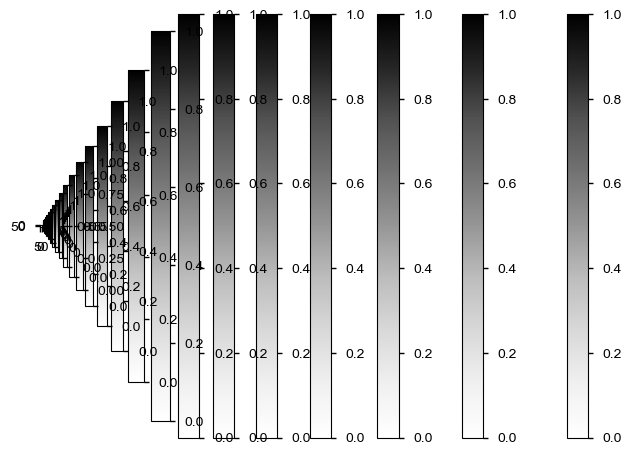

In [311]:
## for the case with NO admixture
cnt = 0; llinc = np.zeros(20,); topedge = np.zeros((20,3),dtype='int')
### llinc[:25] = deepcopy(llinc_null); topedge[:25,:] = deepcopy(topedge_null)
n_rows, n_columns = 8, 10
for n in range(20):
    # smallnodes = np.random.choice(range(80),8,replace=False)
    smallnodes = [12, 62, 9, 37, 25, 48, 53, 76]
    graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, option=2, ss=[2 if i in smallnodes else 20 for i in range(80)]) 
    # lrn = [(23, 56)]

    gen_test_1e = simulate_genotypes(graph, target_n_snps=1500, n_print=1000)
    # gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=2000, n_print=250, long_range_nodes=lrn, admixture_props=[0.25], time_of_adm=[0.00001])

    sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
    sp_Graph.fit(lamb=3., optimize_q='n-dim')
    obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

    lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
    llinc[n] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
    ee = te.iloc[np.argmax(lle),0]
    if ((ee[0] in smallnodes) & (ee[1] in smallnodes)):
        topedge[n,0] += 1
    elif ((ee[0] in smallnodes) | (ee[1] in smallnodes)):
        topedge[n,1] += 1
    else:
        topedge[n,2] += 1  

Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 133 iterations, train_loss=-35390.0514958
lambda=3.0000000, alpha=0.5743409, converged in 7 iterations, train_loss=-36602.9242113
constant-w/variance fit, converged in 133 iterations, train_loss=-35390.0514958
lambda=3.0000000, alpha=0.5743409, converged in 9 iterations, train_loss=-36108.4227041
Starting search for edge 1...
(23, 56), found at index 1.
constant-w/variance fit, converged in 124 iterations, train_loss=-35432.6499801
lambda=3.0000000, alpha=0.5884000, converged in 7 iterations, train_loss=-36745.6293496
Simulating ~SNP 0
Simulating ~SNP 1000
constant-w/variance fit, converged in 131 iterations, train_loss=-35929.1890069
lambda=3.0000000, alpha=0.5891250, converged in 7 iterations, train_loss=-36998.1243836
constant-w/variance fit, converged in 131 iterations, train_loss=-35929.1890069
lambda=3.0000000, alpha=0.5891250, converged in 10 iterations, train_loss=-36566.2673286
Starting search for edg

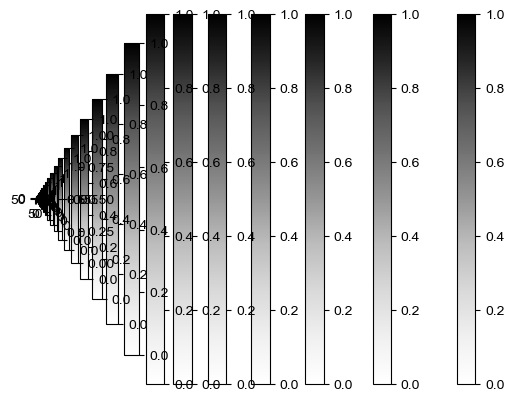

In [143]:
## for the case with admix prop c = [0.25, 0.5, 0.75]
llinc = np.zeros((2,3)); topedge = pd.DataFrame(index=range(2),columns=['0.2','0.5','0.8'])
# n_rows, n_columns = 8, 10
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, n_samples_per_node=30) 
# lrn = [(23, 56)]
for ic, simc in enumerate([0.2,0.5,0.8]):
    for n in range(2):
        gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=1200, n_print=1000, long_range_nodes=lrn, admixture_props=[simc], time_of_adm=[0.0000001])

        sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
        sp_Graph.fit(lamb=3., optimize_q='n-dim')
        obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

        lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
        llinc[n,ic] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
        topedge.iloc[n,ic] = te.loc[np.argmax(lle[:,0])][0]

In [617]:
## for the case with admix prop c = [0.25, 0.5, 0.75] but with bootstrapping
# llinc = np.zeros((15,3)); topedge = pd.DataFrame(index=range(15),columns=['0.125','0.25','0.375'])
# n_rows, n_columns = 8, 10
# graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, n_samples_per_node=20) 
# lrn = [(23, 56)]
# lrnidx = np.zeros((15,3))
lrnidx_ashr = np.zeros((15,3))
for ic, simc in enumerate([0.25,0.5,0.375]):
    cntrec = 0; cnttot = 0
    print('for c={}...'.format(simc))
    for n in range(15):
        ## gen_test_1e = simulate_genotypes_w_admixture(graph, target_n_snps=1200, n_print=1000, long_range_nodes=lrn, admixture_props=[simc], time_of_adm=[0.0000001])
        ##np.savetxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/admixprop/gen80c{}sim{}.txt'.format(simc,n),gen_test_1e)

        gen_test_1e = np.loadtxt('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/admixprop/gen80c{}sim{}.txt'.format(simc,n))

        sp_Graph = Joint_SpatialGraph(gen_test_1e, coord, grid, edge)
        sp_Graph.fit(lamb=3., optimize_q='n-dim', verbose=False)
        obj = Joint_Objective(sp_Graph); obj.inv(); obj.grad(reg=False)

        # res_edges = comp_genetic_vs_fitted_distance(sp_Graph, n_lre=1000, lamb=3., plotFig=False, joint=True)
        # cnttot += lrn[0] in res_edges
        # lrnidx[n,ic] = res_edges.index(lrn[0])
        
        # res_edges = get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj,ntop=600,nchoose=600)
        res_edges = get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj,nreps=30,ntop=600,nchoose=1500,option='ashr')
        try:
            lrnidx_ashr[n,ic] = res_edges.index(lrn[0])
        except:
            lrnidx_ashr[n,ic] = 1000
        # cntrec += lrn[0] in res_edges
        # print('{}/{} out of 15'.format(cntrec,cnttot))
    
        # lle, te = get_best_lre(sp_Graph, gen_test_1e, coord, grid, edge, k=1) ## add a : below if k>1!!!
        # llinc[n,ic] = np.max(lle,axis=0) - np.sort(lle, axis=0)[-2] 
        # topedge.iloc[n,ic] = te.loc[np.argmax(lle[:,0])][0]
        # if (23,56) in new_max_res_node:
        #     print('sim {}: lrn not lost under bootstrapping!'.format(n))
        # else:
        #     print('sad :(')

for c=0.125...
for c=0.25...
for c=0.375...


In [274]:
## include a counter for when both nodes are correctly identified and for when one node is correctly identified
# np.savetxt("/Volumes/GoogleDrive-115041122743441094352/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/llinc1edge8x10.txt",llinc)
# llinc0 = np.loadtxt("/Volumes/GoogleDrive-115041122743441094352/Other computers/My Mac mini/Documents/feemsResults/sims/smallsamp/llinc0edge8x10.txt",skiprows=3)
# topedge.insert(0,'0',[(23,43)]*15)
# sns.swarmplot(data=pd.DataFrame(np.vstack((np.hstack((np.random.choice(llinc0,15).reshape(-1,1),llinc)).flatten(),[0,0.25,0.5,0.75]*15,np.ravel(topedge.apply(lambda x: x==(23,56))))).T,columns=['llinc','edge','true edge']),x='edge',y='llinc',hue='true edge',palette=['grey','k'],alpha=0.8,s=6); plt.legend(title='true edge?'); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('improvement in log-lik over next best edge'); plt.grid(); plt.axhline(15,color='grey',ls='--'); 
# sns.swarmplot(data=pd.DataFrame(np.vstack((lrnidx.flatten()+1,[0.125,0.25,0.375]*15)).T,columns=['lrnidx','c',]),x='c',y='lrnidx',alpha=0.8,s=5,color='k'); plt.xlabel(r'admixture proportion $c$'); plt.ylabel('index of true edge'); plt.title('no threshsolding'); plt.grid(); plt.semilogy()
# lrnidx[:,1], lrnidx_boot[:,1], lrnidx_ashr[:,1]
# plt.plot(lrnidx_boot.flatten()+1,lrnidx.flatten()+1,'ko'); plt.axline((0,0),slope=1,color='grey'); plt.loglog()
# get_boot_edges(gen_test_1e,sp_Graph,coord,grid,edge,obj)

In [230]:
# topedge.sum(axis=0)
# edges_lr = deepcopy(edge)
# edges_lr = edges_lr.tolist()
# edges_lr.append([24,57]); edges_lr.append([1,57]); edges_lr.append([73,78])
# sp_Graph_lr = Joint_SpatialGraph(gen_test_1e, coord, grid, np.array(edges_lr), long_range_edges=[(23,56),(0,56),(72,77)])
# sp_Graph_lr.fit(lamb=3.,optimize_q='n-dim')
# [lle[:,ix].max()-lle[x,ix] for ix, x in enumerate(lle[:,:].T.argsort()[:,-2])]
# lle[:,:].T.argsort()[:,-1]
# (lle-np.max(lle,axis=0).T).argsort(axis=0)[-2,:]
# [sorted(i)[-2] for i in zip(*lle)] 
# np.max(lle,axis=0) - np.sort(lle, axis=0)[-2,:] 
# [te.iloc[np.argmax(lle[:,i]),i]==(23,56) for i in range(3)]
# sns.stripplot(data=pd.DataFrame(np.vstack((llinc.flatten(),[1,2,3]*10,topedge)).T,columns=['llinc','edge','true edge']),x='edge',y='llinc',hue='true edge',palette=['grey','k'],alpha=0.8); plt.legend(title='true edge?'); plt.xlabel('# of edges'); plt.ylabel('improvement in log-lik over next best edge'); plt.grid();
# plt.bar(range(4),[5,2,3,0],color='grey',alpha=0.8); plt.xticks(range(4),labels=['0/3','1/3','2/3','3/3']); plt.xlabel('# of edges b/w small demes (in each sim)'); plt.ylabel('total number (across sims)')
# np.random.choice(range(80),8,replace=False)
## just count the number of possible edges bruh...
# s2stot = 0; s2ltot = 0; l2ltot = 0
# for ii in range(80):
#     for jj in range(ii+1,80):
#         if jj in list(sp_Graph.neighbors(ii)):
#             # if neighboring nodes, do not count as potential long range edges
#             continue
#         if ((ii in smallnodes) & (jj in smallnodes)):
#             s2stot += 1
#         elif (((ii in smallnodes) & (jj not in smallnodes)) | ((ii not in smallnodes) & (jj in smallnodes))):
#             s2ltot += 1
#         else:
#             l2ltot += 1

# s2stot, s2ltot, l2ltot, len(sp_Graph.edges)
## binomial proportion test 
# ZZ = (10/25-s2ltot/2955)/np.sqrt((10/25*15/25)/25 + (s2ltot/2955*(2955-s2ltot)/2955)/2955)

### Checking for variability in different FEEMS fits

Run over a baseline 8x10 grid with no admixture edges & grid with one admixture edge ($c=0.5$).  
Measure edge weights, long range edge detection, log-lik, genetic vs fitted distance, with & without penalty (?).  

1. vanilla FEEMS (constant variance)   
    - nll = -46884 with $\lambda_{CV} = 36$
    - nll = -47455 with $\lambda=3$ (log-lik increases with decreasing $\lambda$, but penalty decreases with increasing $\lambda$)
    - $\mu_w$ = 1.7, $\sigma_w$ = 0.14 & $\mu_w$ = 1.73, $\sigma_w$ = 0.37 (respectively)
    - $q$ = 11.2 (stays the same with different $\lambda$)
2. joint FEEMS (None)
    - same behavior as vanilla FEEMS (similar estimates for similar parameters)
3. joint FEEMS ('1-dim')
    - small difference b/w None and '1-dim': weights stay the same, slight change in q & log-lik
4. joint FEEMS ('n-dim')  
    a. setting $\lambda_q$ & $\alpha_q$  
    b. searching over $\lambda_q$ & $\alpha_q$ 

In [255]:
n_rows, n_columns = 6, 6
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1., barrier_w=1, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)
# gen_test_80 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000, mu=1)

# tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)

# sp_graph = SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=.3); obj = Objective(sp_graph); obj.inv(); 
# np.mean(sp_graph.w), np.std(sp_graph.w)
# fit_cov, _, emp_cov = comp_mats(obj); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
# print(obj.neg_log_lik(), np.mean(sp_graph.w), np.std(sp_graph.w), sp.stats.linregress(fit_dist, emp_dist)[2]**2)
# sp_graph.q
## lamb_grid = np.geomspace(1e-2, 1e2, 10)[::-1]
# cv_err = run_cv(sp_graph_jt, lamb_grid, factr=1e10)
# mean_cv_err = np.mean(cv_err, axis=0)
# print(float(lamb_grid[np.argmin(mean_cv_err)]))

# sp_graph_jt = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def)
# sp_graph_jt.fit(lamb=3., optimize_q=None); obj_jt = Joint_Objective(sp_graph_jt); obj_jt.inv(); 
# fit_cov, _, emp_cov = comp_mats(obj_jt); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
# print(obj_jt.neg_log_lik(), np.mean(sp_graph.w), np.std(sp_graph.w), sp.stats.linregress(fit_dist, emp_dist)[2]**2, sp_graph_jt.q)

# sp_graph_jt.fit(lamb=3., optimize_q='1-dim', lamb_q=0., alpha_q=0.); obj_jt = Joint_Objective(sp_graph_jt); obj_jt.inv(); 
# fit_cov, _, emp_cov = comp_mats(obj_jt); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
# print(obj_jt.neg_log_lik(), np.mean(sp_graph.w), np.std(sp_graph.w), sp.stats.linregress(fit_dist, emp_dist)[2]**2, sp_graph_jt.q)

## try it for with both LRE & base graph
# regpath = pd.DataFrame({'lambq':np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)[:,0], 'alphq':np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)[:,1],'loglik':np.zeros(36),'loss':np.zeros(36),'muw':np.zeros(36),'sigw':np.zeros(36),'R2':np.zeros(36),'muq':np.zeros(36),'sigq':np.zeros(36)})
# for i in range(regpath.shape[0]):    
#     sp_graph_jt.fit(lamb=3., optimize_q='n-dim', lamb_q=regpath['lambq'].iloc[i], alpha_q=regpath['alphq'].iloc[i]); 
#     obj_jt = Joint_Objective(sp_graph_jt); obj_jt.inv(); 
#     fit_cov, _, emp_cov = comp_mats(obj_jt); fit_dist = cov_to_dist(fit_cov)[tril_idx]; emp_dist = cov_to_dist(emp_cov)[tril_idx]
#     regpath['loglik'].iloc[i] = -obj_jt.neg_log_lik(); regpath['muw'].iloc[i] = np.mean(sp_graph_jt.w); regpath['sigw'].iloc[i] = np.std(sp_graph_jt.w)
#     regpath['R2'].iloc[i] = sp.stats.linregress(fit_dist, emp_dist)[2]**2; regpath['muq'].iloc[i] = np.mean(sp_graph_jt.q); regpath['sigq'].iloc[i] = np.std(sp_graph_jt.q)
#     print('{}...'.format(i))

# cvq_err = run_cvq(sp_graph_jt, lamb_cv=10., lamb_q_grid=lamb_grid, alpha_q_grid=lamb_grid, factr=1e6)
# lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,2)))], lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,1)))]

# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# sp_graph_jt.fit(lamb=3., optimize_q='n-dim', lamb_q=1., alpha_q=1.)
# v = Viz(ax, sp_graph_jt, projection=ccrs.Mercator(), edge_width=2, #weights=w,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False)
# # get_best_lre(sp_graph, gen_test_128_adm, coord_def, grid_def, edge_def, k=2, top=10)
# v.draw_edge_colorbar()

# plt.plot(sp_graph_lr.s2, 30/sp_graph_lr.q,'ko')
# 1/sp_graph_lr.s2.mean()

In [160]:
# np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2).shape
# regpath.iloc[0,2:8]
# plt.plot(regpath['R2'],'k-o'); plt.xticks(ticks=range(36),labels=[str(round(x[0],2))+','+str(round(x[1],2)) for x in np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)],rotation=45); plt.ylabel('log-lik'); plt.xlabel(r'$\lambda_q, \alpha_q$')
# plt.plot(regpath['muw'],'ko'); plt.errorbar(range(36),regpath['muw'],regpath['sigw'],color='k'); plt.xticks(ticks=range(36),labels=[str(round(x[0],2))+','+str(round(x[1],2)) for x in np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)],rotation=45); plt.ylabel(r'$\hat w$'); plt.xlabel(r'$\lambda_q, \alpha_q$')
# plt.plot(regpath['muq'],'ko'); plt.errorbar(range(36),regpath['muq'],regpath['sigq'],color='k'); plt.xticks(ticks=range(36),labels=[str(round(x[0],2))+','+str(round(x[1],2)) for x in np.array(np.meshgrid(np.logspace(-2,2,6),np.logspace(-2,2,6))).T.reshape(-1,2)],rotation=45); plt.ylabel(r'$\hat q$'); plt.xlabel(r'$\lambda_q, \alpha_q$')

## From msprime documentation: 

As described in the Definitions section, continuous migration between populations is modelled by a matrix of rates, so that $M[j, k]$ is the rate at which lineages move from population $j$ to population $k$ in the coalescent process, that is, backwards in time (see the Direction of time section for more details). Lineages that move from population $j$ to $k$ backwards in time actually correspond to individuals migrating from population $k$ to $j$ forwards in time.

In [836]:
def comp_fst_mat(genotypes, n_inds, n_demes):
    """Computes an Fst distance matrix from a sample
    genotype matrix and set of sub-population ids
    """
    n_snps = genotypes.shape[1]
    acs = np.empty((n_demes, n_snps, 2))
    
    # compute allele counts
    for i in range(n_demes):
        Gi = genotypes[np.arange(i*n_inds,(i+1)*n_inds), :]
        acs[i, :, 0] = np.sum(Gi, axis=0)
        acs[i, :, 1] = (2 * Gi.shape[0]) - np.sum(Gi, axis=0) 
    
    # compute Fst matrix
    Fst = np.empty((n_demes, n_demes))
    for i in range(n_demes):
        for j in range(n_demes):
            Fst[i, j] = np.sum(allel.mean_pairwise_difference_between(acs[i, :, :].astype(np.int32), acs[j, :, :].astype(np.int32)))/n_snps

    for i in range(n_demes):
        Fst[i, i] = np.sum(allel.mean_pairwise_difference(acs[i, :, :].astype(np.int32)))/n_snps
    return(Fst)

# Fst = comp_fst_mat(gen_test1,20,12)
# plt.imshow(sp_Graph_asym.S,cmap='RdBu_r'); plt.colorbar()

In [346]:
# def avg_coal_time(tree):
#     coalescence_time = 0
#     sample_size = tree.get_sample_size()
#     for leaves in tree.samples():
#         num_branch = 0
#         u = leaves
#         visited = np.array([u])
#         while u != tskit.NULL:
#             u = tree.parent(u)
#             if u !=-1 :
#                 node_children = np.array(tree.children(u))
#                     #print("{}:{}".format(u, node_children))                                                                                               
#                 node_interest = np.setdiff1d(node_children, visited)
#                 if len(node_interest)!=0:
#                     for j in range(len(node_interest)):
#                         num_leaves = tree.get_num_leaves(node_interest[j])
#                         node_branch_len = tree.time(u) * num_leaves
#                         coalescence_time = coalescence_time + node_branch_len
#                         visited = np.append(visited, u)
#                         num_branch =+ num_leaves

#         #print("leaves{}:{},{}".format(leaves, num_branch, visited))                                                                                       
#     return(coalescence_time/(sample_size * (sample_size-1)))

In [1146]:
## reading in trees from SLiM (https://github.com/petrelharp/isolation_by_coalescence)
# origts = tskit.load("/Users/vivaswat/feems/docs/notebooks/results/slimtrees/pop_10000.trees")
origtree = []
for t in origts.trees():
    origtree.append(t)